In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit import VideoReader, VideoWriter, TrainingGenerator

import time
from os.path import expanduser
HOME = expanduser("~")

Using TensorFlow backend.


In [3]:
models = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*model*.h5'))
models

['/home/jake/deepposekit-data/datasets/fly/best_model_fly_densenet.h5']

In [4]:
model = load_model(models[0])

/home/jake/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
videos = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*video.avi'))
videos

['/home/jake/deepposekit-data/datasets/fly/video.avi']

In [15]:
reader = VideoReader(videos[0], batch_size=5000, gray=True)
frames = reader[0]
frames[frames < 50] = 0 # Threshold to match the training set from Pereira et al.
reader.close()

True

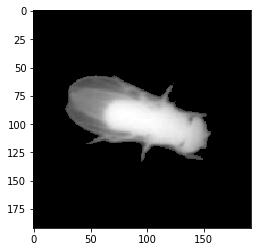

In [16]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

In [17]:
predictions = model.predict(frames, batch_size=100, verbose=1)
row, col, confidence = np.split(predictions, 3, -1)

5000/5000 [==============================] - 8s 2ms/step


In [18]:
confidence_maps = model.train_model.predict(frames, verbose=1, batch_size=100)[-1]

5000/5000 [==============================] - 14s 3ms/step


In [19]:
annotations = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*annotation*.h5'))
train_generator = TrainingGenerator(annotations[0])

predictions *= (160./192.)
predictions *= 3

In [20]:
# TODO: Turn this into a function
cmap = plt.cm.hsv(np.linspace(0, 1, train_generator.n_keypoints))[:, :3][:, ::-1] * 255
cmap1 = plt.cm.hsv(np.linspace(0, 1, 7))[:, :3][:, ::-1] * 255

writer = VideoWriter(HOME + '/fly_posture.mp4', 'MP4V', 30.0, (160*2*3,160*2*3))

for frame, coords, conf_map in zip(frames, predictions, confidence_maps):
    frame = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame = cv2.resize(frame, (160*3, 160*3))
    frame = cv2.bitwise_not(frame)
    original_frame = frame.copy()
    for idx, node in enumerate(train_generator.graph):
        if node >= 0:
            pt1 = coords[idx]
            pt2 = coords[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, coord in enumerate(coords):
        coord = coord.astype(int)
        cv2.circle(frame, (coord[0], coord[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    conf_maps_color = np.repeat(np.moveaxis(conf_map[...,train_generator.n_keypoints:train_generator.n_keypoints + train_generator.n_branches], -1, 0)[..., None], 3, axis=-1)
    conf_maps_color /= conf_maps_color.reshape(7, -1).max(1)[:, None, None, None]
    conf_maps_color *= np.repeat(np.repeat(cmap1[:, None, None,...], conf_map.shape[0], 1), conf_map.shape[1], 2)
    conf_maps_color = conf_maps_color.max(0).astype(np.uint8)
    conf_maps_color = cv2.resize(conf_maps_color, (160*3,160*3), interpolation=cv2.INTER_NEAREST)
    top = np.concatenate((original_frame, conf_maps_color), axis=1)
    
    conf_maps_color = np.repeat(np.moveaxis(conf_map[...,:train_generator.n_keypoints], -1, 0)[..., None], 3, axis=-1)
    conf_maps_color /= conf_maps_color.reshape(train_generator.n_keypoints, -1).max(1)[:, None, None, None]
    conf_maps_color *= np.repeat(np.repeat(cmap[:, None, None,...], conf_map.shape[0], 1), conf_map.shape[1], 2)
    conf_maps_color = conf_maps_color.max(0).astype(np.uint8)
    conf_maps_color = cv2.resize(conf_maps_color, (160*3,160*3), interpolation=cv2.INTER_NEAREST)
    bottom = np.concatenate((conf_maps_color, frame), axis=1)
    frame = np.concatenate((top, bottom), axis=0)
    writer.write(frame)

writer.close()  

True

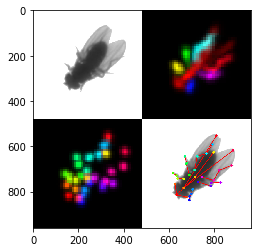

In [21]:
plt.imshow(frame[...,::-1])
plt.show()

In [ ]:
# TODO: Add code for selecting and merging new data